객체 탐지
  - 모델
    - R-CNN
    - Fast R-CNN
    - Faster R-CNN
    - YOLO(You Only Look One)

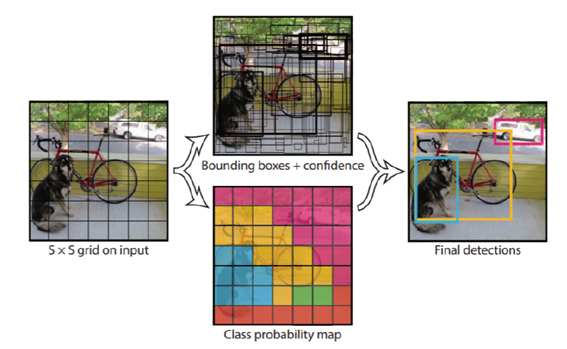

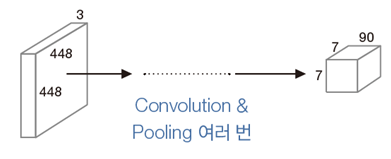

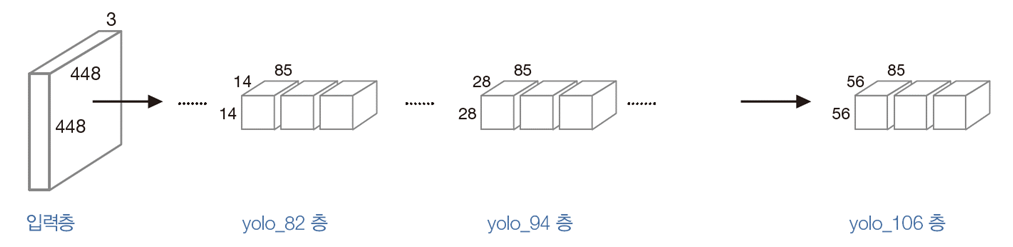

In [24]:
import numpy as np
import cv2

In [25]:
!unzip /content/drive/MyDrive/yolo/yolo.zip -d ./yolo/

Archive:  /content/drive/MyDrive/yolo/yolo.zip
replace ./yolo/coco.names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./yolo/coco.names.txt   
  inflating: ./yolo/yolo_test.jpg    
  inflating: ./yolo/yolov3.cfg       
  inflating: ./yolo/yolov3.weights   


In [34]:
# MS COCO 데이터셋에 대해 학습되어 있음  80개 CLASS
classes = []
with open('/content/yolo/coco.names.txt', 'r') as f:
  classes = [line.strip() for line in f.readlines()]
colors = np.random.uniform(0,255,size=(len(classes),3) )
img = cv2.imread('/content/test.jpg')
height,width,channels =  img.shape
blob =  cv2.dnn.blobFromImage(img,1.0/256,(448,448),(0,0,0),swapRB=True,crop=False)
model = cv2.dnn.readNet('/content/yolo/yolov3.weights','/content/yolo/yolov3.cfg')

In [35]:
layer_names = model.getLayerNames()
out_layers = [ layer_names[i-1] for i in model.getUnconnectedOutLayers()]
out_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [36]:
# 테스트 영상을 신경망에 입력
model.setInput(blob)
outputs = model.forward(out_layers)  # 출력을 outpus에 저장

In [37]:
class_ids,confidences,boxes = [],[],[]
# outputs  모델에 대한 검출한 객체의 정보를 담고 있음
for output_ in outputs:
  for vec85 in output_:  # vec85 객체의 정보를 담고 있는 벡터
    scores = vec85[5:]  # 최고 부류 확률이 0.5를 넘는 바운딩 박스  클래스의 확률 점수
    class_id = np.argmax(scores)
    confidence=scores[class_id] # 선택된 클래스에 해당하는 신뢰도 값을 가져옮
    if confidence>0.5: # 신뢰도가 50% 이상인 경우만 취함
        centerx,centery=int(vec85[0]*width),int(vec85[1]*height)  # 중심좌표를 이미지 크기에 맞게 변환
        w,h=int(vec85[2]*width),int(vec85[3]*height) # 너비와 높이를 조정
        x,y=int(centerx-w/2),int(centery-h/2) # 좌상단 좌표를 계산
        boxes.append([x,y,w,h]) # 감지된 객체의 좌표와 크기를 boxes 리스트에 저장
        confidences.append(float(confidence))
        class_ids.append(class_id)
# Non-Maximum Supperssino(NMS)을 사용
# 겹치는 박스를 제거, 겹치는 박스중에 가장 신뢰도가 높은 박스들의 좌표만 남겨둔다
indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)

In [38]:
for i in range(len(boxes)):
  if i in indexes:
    x,y,w,h=boxes[i]
    text=str(classes[class_ids[i]])+'%.3f'%confidences[i]
    cv2.rectangle(img,(x,y),(x+w,y+h),colors[class_ids[i]],2)
    cv2.putText(img,text,(x,y+30),cv2.FONT_HERSHEY_PLAIN,2,colors[class_ids[i]],2)

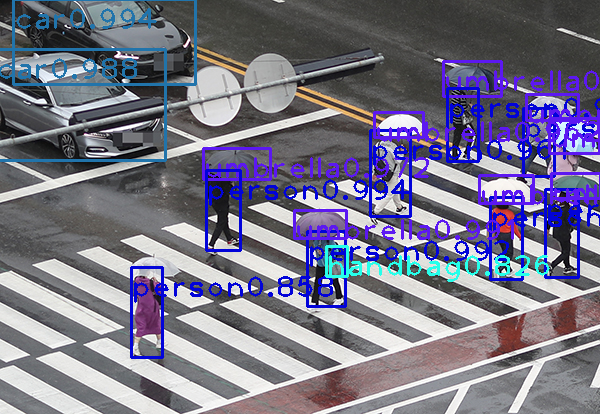

In [39]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()